## **New York Times Data Collection**

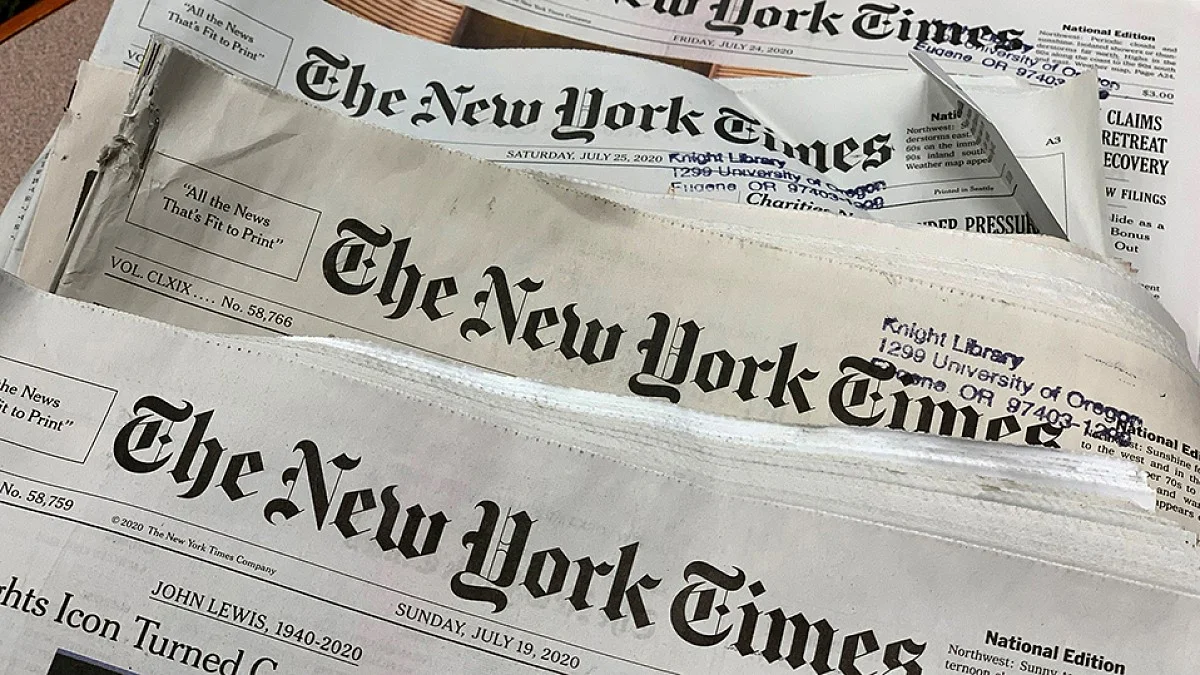

# Importing New York Times News Category Dataset and Sentiment Analysis

In [1]:
pip install textblob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Now we are going to scrape data from the New York Times API, processes it, and stores it in a CSV file. Here's what it does:**

*   import statements bring in necessary Python libraries.
*   An API key is initialized to an API key obtained from the New York Times API, which is required to access the data.
*   **start_date** and **end_date** are defined as date objects representing the start and end dates of the range of data to be scraped from the API.
*   A **while** loop iterates through each month in the date range and sends a request to the API to get data for that month. The data is added to a dictionary called **ny_data**, and a list called all_articles is extended with the articles retrieved.
*   The **all_articles** list is filtered to only include articles from the sections "Business Day", "Technology", and "Real Estate", published within the specified date range. For each article, the sentiment of the headline and abstract is calculated using the **SentimentIntensityAnalyzer** class from the **nltk** library.
*   The filtered articles and their sentiment scores are stored in a Pandas DataFrame called **cleaned_ny_data_df**.
*   The DataFrame is grouped by date and the mean and median sentiment scores are calculated for both the headline and the article body. The resulting DataFrame is saved to a CSV file called "ny_times_data.csv".




In [3]:
import requests
import os
import json
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import datetime, timedelta

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

apikey = os.getenv('NYTIMES_APIKEY', 'SqzyHe7mmHI7o9uARoryVwi8wCVHdKzJ')

start_date = datetime.strptime('2022-03-13', "%Y-%m-%d")
end_date = datetime.strptime('2022-09-13', "%Y-%m-%d")

ny_data = {}
all_articles = []

# Iterate through months in the date range
current_date = start_date
while current_date <= end_date:
    year = current_date.year
    month = current_date.month

    query_url = f"https://api.nytimes.com/svc/archive/v1/{year}/{month}.json?api-key={apikey}"

    r = requests.get(query_url)
    ny_data.update(r.json())
    all_articles.extend(ny_data['response']['docs'])

    # Move to the next month
    if current_date.month == 12:
        current_date = current_date.replace(year=current_date.year + 1, month=1)
    else:
        current_date = current_date.replace(month=current_date.month + 1)

# Filter articles and calculate sentiment
filtered_articles = []
for doc in all_articles:
    sec_name = doc['section_name']
    if sec_name not in ['Business Day', 'Technology', 'Real Estate']:
        continue

    pub_date = doc['pub_date']
    date = datetime.strptime(pub_date.split('T')[0], "%Y-%m-%d").date()
    if date < start_date.date() or date > end_date.date():
        continue

    headline = doc['headline']['main']
    abstract = doc['abstract']

    headline_sentiment = sia.polarity_scores(headline)['compound']
    abstract_sentiment = sia.polarity_scores(abstract)['compound']

    filtered_articles.append({
        'pub_date': str(date),
        'headline': headline,
        'abstract': abstract,
        'section': sec_name,
        'headline_sentiment': headline_sentiment,
        'abstract_sentiment': abstract_sentiment
    })

# Create DataFrame
cleaned_ny_data_df = pd.DataFrame(filtered_articles)

# Group by date and calculate mean and median sentiment scores
grouped_data = cleaned_ny_data_df.groupby('pub_date').agg({
    'headline_sentiment': ['mean', 'median'],
    'abstract_sentiment': ['mean', 'median']
}).reset_index()

# Flatten the multi-level column names
grouped_data.columns = ['_'.join(col).strip() for col in grouped_data.columns.values]

# Rename columns
grouped_data.columns = ['Date', 'Headline Mean', 'Headline Median', 'Body Mean', 'Body Median']

# Set the 'Date' column as the index of the grouped_data DataFrame
grouped_data.set_index('Date', inplace=True)

# Round the sentiment scores to two decimal places
grouped_data_rounded = grouped_data.round(2)

# Reindex the DataFrame to include the entire date range
start_date = pd.to_datetime('2022-03-13')
end_date = pd.to_datetime('2022-09-13')
date_range = pd.date_range(start_date, end_date, freq='D')
grouped_data_rounded_reindexed = grouped_data_rounded.reindex(date_range)

# Save the entire rounded grouped_data DataFrame to a CSV file
grouped_data_rounded.to_csv("ny_times_data.csv")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


**The sentiment scores** are then stored along with other information such as publication date, headline, and abstract in a dictionary and appended to the **filtered_articles** list.

A Pandas DataFrame called **cleaned_ny_data_df** is created from the filtered_articles list.

The cleaned_ny_data_df DataFrame is then grouped by date, and the maximum and minimum sentiment scores for both the headline and the article body are calculated. The resulting DataFrame is saved to a CSV file called "ny_times_data_max_min.csv".

The code follows a similar structure to the previous one, but instead of calculating the mean and median sentiment scores, it calculates the maximum and minimum scores. The resulting DataFrame provides a different perspective on the sentiment of the articles in the specified date range.

In [4]:
# Filter articles and calculate sentiment
filtered_articles = []
for doc in all_articles:
    pub_date = doc['pub_date']
    date = datetime.strptime(pub_date.split('T')[0], "%Y-%m-%d").date()
    if date < start_date.date() or date > end_date.date():
        continue

    headline = doc['headline']['main']
    abstract = doc['abstract']

    headline_sentiment = sia.polarity_scores(headline)['compound']
    abstract_sentiment = sia.polarity_scores(abstract)['compound']

    filtered_articles.append({
        'pub_date': str(date),
        'headline': headline,
        'abstract': abstract,
        'section': doc['section_name'],
        'headline_sentiment': headline_sentiment,
        'abstract_sentiment': abstract_sentiment
    })

# Create DataFrame
cleaned_ny_data_df = pd.DataFrame(filtered_articles)

# Group by date and calculate max and min sentiment scores
grouped_data = cleaned_ny_data_df.groupby('pub_date').agg({
    'headline_sentiment': ['max', 'min'],
    'abstract_sentiment': ['max', 'min']
}).reset_index()

# Flatten the multi-level column names
grouped_data.columns = ['_'.join(col).strip() for col in grouped_data.columns.values]

# Rename columns
grouped_data.columns = ['Date', 'Headline Max', 'Headline Min', 'Body Max', 'Body Min']

# Set the 'Date' column as the index of the grouped_data DataFrame
grouped_data.set_index('Date', inplace=True)

# Round the sentiment scores to two decimal places
grouped_data_rounded = grouped_data.round(2)

# Save the entire rounded grouped_data DataFrame to a CSV file
grouped_data_rounded.to_csv("ny_times_data_max_min.csv")

**Now,** we are going to merge the two dataframes **df1** and **df2** using the **date** column as the key. This is done using the merge function from the Pandas library.

The resulting merged dataframe is assigned to a new variable called **merged_df**. The columns in the dataframe are then reordered so that the date column is first, followed by the mean and median sentiment scores for the headline and article body, and finally the maximum and minimum sentiment scores for the headline and article body.

**Finally**, the merged dataframe is written to a new CSV file called **"ny_times_merged_data.csv"** using the to_csv function from the Pandas library, with the index parameter set to False to exclude the index column from the CSV file. The resulting file contains all the sentiment scores calculated in the previous codes in a single dataframe, making it easier to analyze the data.

In [5]:
# Read in the two CSV files
df1 = pd.read_csv('ny_times_data.csv')
df2 = pd.read_csv('ny_times_data_max_min.csv')

# Merge the two dataframes using the date column as the key
merged_df = pd.merge(df1, df2, on='Date')

# Reorder the columns so that the date column is first
merged_df = merged_df[['Date', 'Headline Mean', 'Headline Median', 'Body Mean', 'Body Median', 'Headline Max', 'Headline Min', 'Body Max', 'Body Min']]

# Write the merged dataframe to a new CSV file
merged_df.to_csv('ny_times_merged_data.csv', index=False)
